In [1]:
%load_ext cython
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sequencing_tools.fastq_tools import reverse_complement, onehot_sequence_encoder
from operator import itemgetter
from collections import defaultdict
import random
import numpy as np
from torch.autograd import Variable
import pyximport
pyximport.install()
import matplotlib.pyplot as plt
from utils.bed_utils import data_generator
import time
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from torch.autograd.profiler import profile

acceptable_nuc = list('ACTGN')
dna_encoder = onehot_sequence_encoder(''.join(acceptable_nuc))

def generate_seq(n = 100):
    X = []
    y = []
    for i in range(n):
        seq = [random.choice(list('ACTG')) for i in range(400)]
        seq = ''.join(seq)
        label = random.choice([0,1])
        X.append(dna_encoder.transform(seq).transpose())
        y.append(label)
    return np.array(X), np.array(y)

In [21]:
class Deep_cfNA(nn.Module):
    def __init__(self):
        super(Deep_cfNA, self).__init__()
        self.conv_1d = nn.Conv1d(in_channels=len(acceptable_nuc),
                                 out_channels=160,
                                kernel_size=26,
                                stride=1)
        self.LSTM = nn.LSTM(input_size=26, hidden_size=64,
                            batch_first=True, bidirectional=True)
        self.linear1 = nn.Linear(4160, 50)
        self.linear2 = nn.Linear(50, 25)
        self.linear3 = nn.Linear(25, 1)
        
    def initialize_weight(self):
        for name, param in self.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                nn.init.xavier_normal_(param)
        
    def forward(self, x):
        y = self.conv_1d(x)
        y = F.relu(y)
        y = F.max_pool1d(y, kernel_size=50, stride=13)
        batch_size = y.size(0)
        y = y.view(batch_size, -1)
        y = F.dropout(y, p = 0.2)
        #y, (hidden, cell_state)= self.LSTM(y)
        #y = y[:, -1]
        y = F.dropout(y, p = 0.5)
        y = self.linear1(y)
        y = self.linear2(y)
        y = self.linear3(y)
        y = F.sigmoid(y)
        return y
    
    def lstm_layer(self, x):
        y = self.conv_1d(x)
        #print('conv1d:', y.shape)
        y = F.max_pool1d(F.relu(y), kernel_size=50, stride=13)
        #print('max pool:', y.shape)
        y = F.dropout(y, p = 0.2)
        y, (hidden, cell_state)= self.LSTM(y)
        return y

In [22]:
work_dir = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/classifier'
DNA_bed = work_dir + '/train_DNA.bed'
RNA_bed = work_dir + '/train_RNA.bed'
fa = '/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa'
batch = 500

gen_data = data_generator(RNA_bed, DNA_bed, fa, batch_size=batch, seed = 1, N_padded=True)

In [23]:
model = Deep_cfNA()
model.initialize_weight()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
losses = []
steps = 200

for step in range(steps):
    start = time.time()
    optimizer.zero_grad()
    X,y = next(gen_data)
    X.requires_grad_()
    pred_y = model(X)
    loss = F.binary_cross_entropy(pred_y.view(-1), y)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    end = time.time()
    if (step+1) % 20 == 0:
        print('[{step}/{steps}] loss: {loss}, used {time} sec'\
                .format(step = step + 1, 
                        steps=steps, 
                        loss = '%.3f' %loss.item(), 
                        time = '%.3f' %(end-start)))

[20/200] loss: 0.246, used 1.625 sec
[40/200] loss: 0.194, used 1.489 sec
[60/200] loss: 0.177, used 1.584 sec
[80/200] loss: 0.126, used 1.536 sec
[100/200] loss: 0.141, used 1.557 sec
[120/200] loss: 0.104, used 1.616 sec
[140/200] loss: 0.099, used 1.777 sec
[160/200] loss: 0.137, used 1.608 sec
[180/200] loss: 0.124, used 1.440 sec
[200/200] loss: 0.111, used 1.526 sec


/stor/work/Lambowitz/cdw2854/src/miniconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


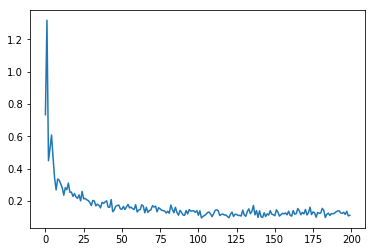

In [24]:
plt.plot(losses)

In [38]:
X.grad.shape

torch.Size([500, 5, 400])

In [39]:
X

tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        ...,

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0

In [25]:
help(nn.Linear)

Help on class Linear in module torch.nn.modules.linear:

class Linear(torch.nn.modules.module.Module)
 |  Applies a linear transformation to the incoming data: :math:`y = Ax + b`
 |  
 |  Args:
 |      in_features: size of each input sample
 |      out_features: size of each output sample
 |      bias: If set to False, the layer will not learn an additive bias.
 |          Default: ``True``
 |  
 |  Shape:
 |      - Input: :math:`(N, *, in\_features)` where :math:`*` means any number of
 |        additional dimensions
 |      - Output: :math:`(N, *, out\_features)` where all but the last dimension
 |        are the same shape as the input.
 |  
 |  Attributes:
 |      weight: the learnable weights of the module of shape
 |          `(out_features x in_features)`
 |      bias:   the learnable bias of the module of shape `(out_features)`
 |  
 |  Examples::
 |  
 |      >>> m = nn.Linear(20, 30)
 |      >>> input = torch.randn(128, 20)
 |      >>> output = m(input)
 |      >>> print(outp